This notebook tries to replicate what is done [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb)  but in Pytorch.

Reference: [Distill.pub / Differentiable Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


import torch

from torchvision import models

import numpy as np

import PIL.Image
import urllib

import matplotlib.pyplot as plt

from pyimgy.optional.torch import *
from netlens.style_transfer import *

Inception V1 is GoogLeNet according to [this](https://pytorch.org/docs/stable/torchvision/models.html#id23)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Optional: clearing CUDA memory

In [3]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    from pynvml import *
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print("Total memory:", info.total)
    print("Free memory:", info.free)
    print("Used memory:", info.used)
    
    torch.cuda.memory_allocated()

In [4]:
model = models.googlenet(pretrained=True).to(device)

In [5]:
def load(url):
    img = PIL.Image.open(urllib.request.urlopen(url))
    return np.array(img)

(512, 512, 3) (512, 645, 3)


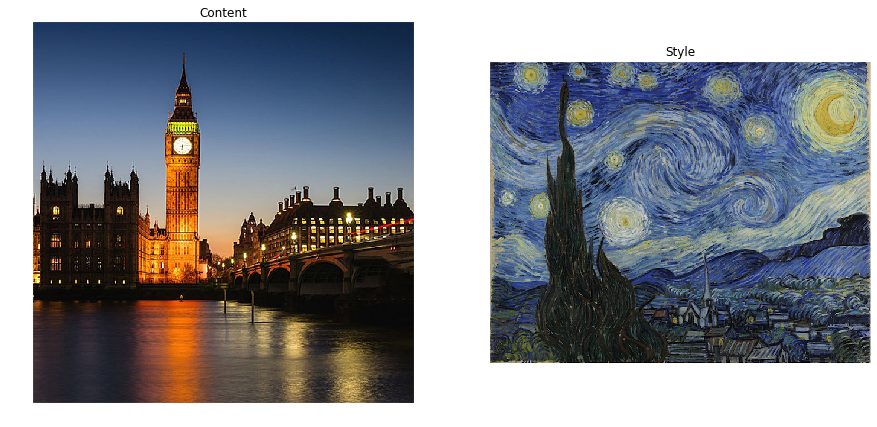

In [6]:
# how to load images from URLs?

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show_images([content_image, style_image], ['Content', 'Style'])

In [7]:
type(content_image)

numpy.ndarray

The InceptionV1 layers from TF are like this: (compare with the Pytorch model)

```
[Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
  Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <head1_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn1: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax1: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax2: 1008> ([{'dense'}])]
 19
 ```
 
 And the layers to plug into are:
 ```
 style_layers = [
  'conv2d2',  # conv3
  'mixed3a',  # inception3a
  'mixed4a',  # inception3b
  'mixed4b',  # inception4b
  'mixed4c',  # inception4c
]

content_layers = [
  'mixed3b',  # inception3b
]
 ```

In [8]:
print('\n'.join(model._modules.keys()))

conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [9]:
model
model.transform_input = False

In [10]:
len(model._modules)

19

In [11]:
style_layers = [
  'conv3',
  'inception3a',
  'inception4a',
  'inception4b',
  'inception4c',
]

content_layers = [
  'inception3b',
]

In [12]:
arch = FlatModel.from_custom_model(model)

In [13]:
#arch.prep

In [14]:
from fastai.layers import Lambda

arch.prepend('normalization', Lambda(lambda x: 2*x - 1)) #center the values of Google net

In [15]:
arch.summary()

    # | LAYER           | MODULE
--------------------------------------------------------------------------------
    0 | normalization   | Lambda()
    1 | conv1           | BasicConv2d: [(conv): Conv2d, (bn): BatchNorm2d
    2 | maxpool1        | MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    3 | conv2           | BasicConv2d: [(conv): Conv2d, (bn): BatchNorm2d
    4 | conv3           | BasicConv2d: [(conv): Conv2d, (bn): BatchNorm2d
    5 | maxpool2        | MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    6 | inception3a     | Inception: [(branch1): BasicConv2d, (branch2): Sequential, (branch3): Sequential, (branch4): Sequential
    7 | inception3b     | Inception: [(branch1): BasicConv2d, (branch2): Sequential, (branch3): Sequential, (branch4): Sequential
    8 | maxpool3        | MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    9 | inception4a     | Inception: [(branch1): BasicConv2d, (branch

In [16]:
list(arch.layers.keys())

['normalization',
 'conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'flatten',
 'dropout',
 'fc']

In [17]:
min(content_image.shape[:2])

512

In [18]:
#arch.prepend('image_param', image_param)

In [19]:
import torchvision.transforms as T
import netlens.transforms as T2

def transform_inputs(content_image, style_image, zoom=1.0):
    content_tfms = T.Compose([T.ToPILImage(), T2.Zoom(zoom), T.ToTensor()])
    content_input = content_tfms(content_image).unsqueeze(0)
    style_tfms = T.Compose([T.ToPILImage(), T2.Zoom(zoom), T.RandomCrop(content_input.shape[-2:]), T.ToTensor()])
    style_input = style_tfms(style_image).unsqueeze(0)
    return content_input, style_input

In [20]:
content_input, style_input = transform_inputs(content_image, style_image, 1.0)

In [21]:
content_input = content_input.to(device)
style_input = style_input.to(device)

In [22]:
import torch.nn.functional as F
from netlens.math import gram_matrix, gram_matrix_2

style_module = StyleTransferModule(arch, content_input, content_layers, style_input, style_layers, 
                                   style_transform=gram_matrix_2, loss_func=F.l1_loss)

In [23]:
class STCallback(OptVisCallback):
    def on_step_end(self, optvis, img, *args, **kwargs):
        if optvis.is_step_to_show():
            print(f'Style loss={optvis.objective.style_loss}, Content loss={optvis.objective.content_loss}, TV loss={optvis.objective.tv_loss}')

In [24]:
style_obj = StyleTransferObjective(style_module, style_weight=1, content_weight=100)

In [25]:
import torch.optim
from netlens.visualization.render import *

# optvis = OptVis(style_module, style_obj, optim=optim.Adam, optim_params={'lr': 0.05})
optvis = OptVis(style_module, style_obj, optim=optim.LBFGS)

In [26]:
content_input.shape

torch.Size([1, 3, 512, 512])

In [34]:
# we need to pre-prend the "layer" of the parameterization
from netlens.visualization import param

image_param = param.ImageParam(im_initial=content_input, fft=True, decorrelate=True, norm_stats=None)

Run [50], loss=22.5144


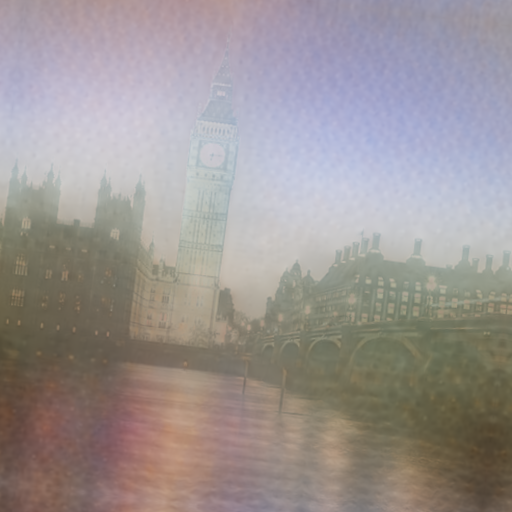

Style loss=0.05847089737653732, Content loss=22.455963134765625, TV loss=0.0
Run [100], loss=19.5623


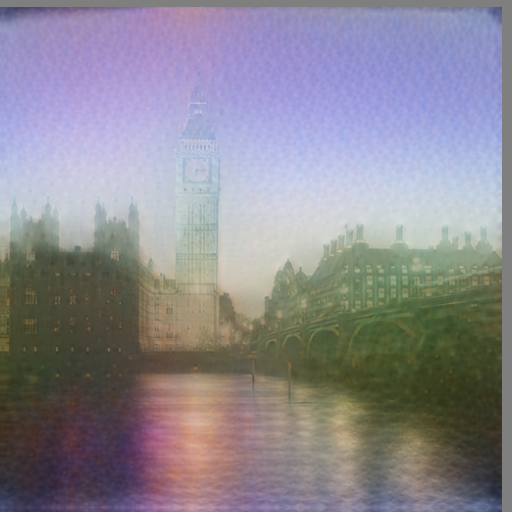

Style loss=0.06336259096860886, Content loss=19.49889373779297, TV loss=0.0
Run [150], loss=22.5516


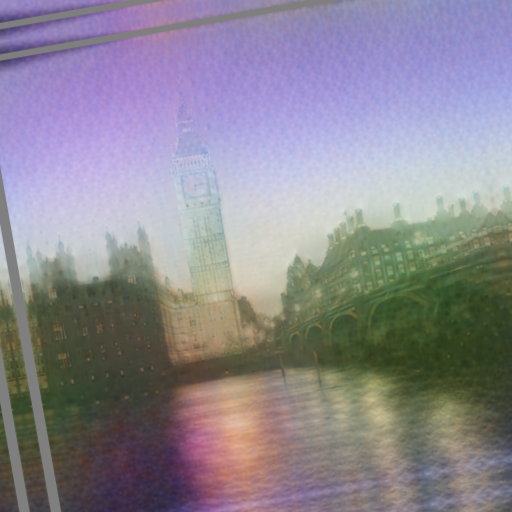

Style loss=0.06200201064348221, Content loss=22.4896297454834, TV loss=0.0
Run [200], loss=21.1541


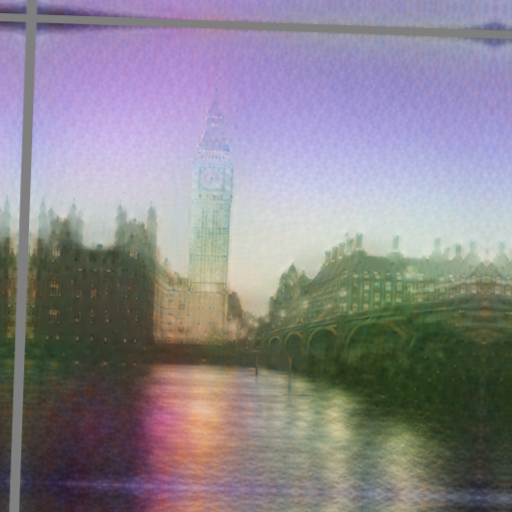

Style loss=0.06305144727230072, Content loss=21.09108543395996, TV loss=0.0


In [35]:
output = optvis.vis(image_param, thresh=tuple(range(50, 250, 50)), transform=True, in_closure=True, show=True, 
                    callback=STCallback())

In [ ]:
#trials = [10000, 140000, 160000]

In [36]:
raw_output = image_param()

In [41]:
output = image_param.denormalize(raw_output)

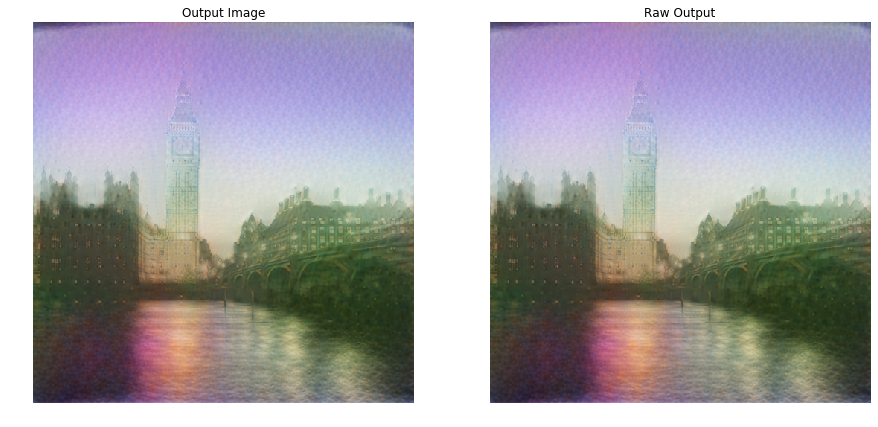

In [42]:
show_images([output, raw_output], ['Output Image', 'Raw Output'])

In [43]:
raw_output.min(), raw_output.max()

(tensor(0.0782, grad_fn=<MinBackward1>),
 tensor(0.9294, grad_fn=<MaxBackward1>))

In [44]:
output.min(), output.max()

(tensor(0.0782, grad_fn=<MinBackward1>),
 tensor(0.9294, grad_fn=<MaxBackward1>))

### Bonus: Testing the FFT

In [ ]:
sp_i, get_image_i = param.fourier_image(im_initial=content_input)

In [ ]:
im_rec = get_image_i(sp_i).clamp(min=0.0, max=1.0)

In [ ]:
def normalize_to_range(t):
    # t = torch.sigmoid(t)
    return (t - t.min()) / (t.max() - t.min())

In [ ]:
show_images([content_input, im_rec, normalize_to_range(sp_i[...,0]), normalize_to_range(sp_i[...,0])],
            ['Original', 'Recovered', 'FFT Re', 'FFT Im'], r=2)

In [ ]:
sp_i.max(), sp_i.min()

In [ ]:
im_rec.max(), im_rec.min()